# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [6]:
import pandas as pd
import numpy as np
import math
import json


from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
import seaborn as sns #For Data visualization
import matplotlib.pyplot as plt #Data plotting and visualization
sns.set_palette(sns.color_palette('Set2'))
import plotly.express as px
%matplotlib inline


In [7]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [8]:
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.cluster import KMeans

In [9]:
#Import functions
from clean_data import clean_portfolio, clean_profile, clean_transcript


portfolio_df = clean_portfolio(portfolio)
portfolio_df = portfolio_df[['offer_reward', 'channels', 'offer_difficulty', 
                             'offer_duration', 'offer_type', 'offer_id', 'offer_name']]

profile_df = clean_profile(profile)
profile_df = profile_df[['gender','age', 'customer_id','became_member_on',
            'customer_income','membership_year','age_group']]

offers_df,transactions_df  = clean_transcript(transcript)


In [10]:
offers_df = offers_df[['customer_id', 'event', 'time_in_days', 'offer_id']]
offers_df

,customer_id,event,time_in_days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,29,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,29,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,29,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,29,fafdcd668e3743c1bb461111dcafc2a4


In [11]:
profile_df

,gender,age,customer_id,became_member_on,customer_income,membership_year,age_group
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,GenXers(44-56)
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,Boomers(57-75)
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,Boomers(57-75)
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,Boomers(57-75)
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,Boomers(57-75)
...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,GenXers(44-56)
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,Boomers(57-75)
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,GenXers(44-56)
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,Matures(76+)


## Portfolio: Data Exploration 

In [12]:
display(portfolio)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [13]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


## Profile: Data Exploration

In [14]:
profile_df

,gender,age,customer_id,became_member_on,customer_income,membership_year,age_group
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,GenXers(44-56)
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,Boomers(57-75)
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,Boomers(57-75)
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,Boomers(57-75)
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,Boomers(57-75)
...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,GenXers(44-56)
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,Boomers(57-75)
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,GenXers(44-56)
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,Matures(76+)


In [15]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


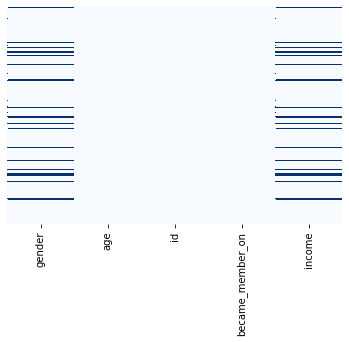

In [16]:
# Find and visualize Missing Data
sns.heatmap(profile.isnull(), yticklabels = False, cbar = False, cmap="Blues")

profile.info()

In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [18]:
print(pd.DataFrame(profile_df['age'].describe()))
print('')
print(pd.DataFrame(profile_df['customer_income'].describe()))

                age
count  14825.000000
mean      54.393524
std       17.383705
min       18.000000
25%       42.000000
50%       55.000000
75%       66.000000
max      101.000000

       customer_income
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000


<AxesSubplot:xlabel='age'>

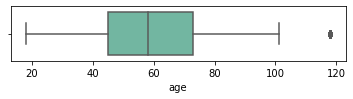

In [19]:
plt.figure(figsize=[6,1])
sns.boxplot(data=profile, x='age')

In [20]:
profile_df = profile_df[profile_df['customer_income'].notnull()]
print(profile_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   customer_income   14825 non-null  float64       
 5   membership_year   14825 non-null  int64         
 6   age_group         14825 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 825.4+ KB
None


Median Age  : $ 55.0


Text(0.5, 1.0, 'Age Distribution')

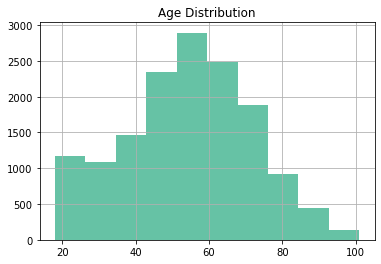

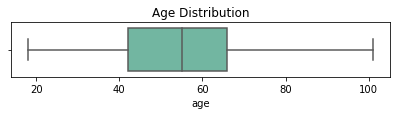

In [21]:
# Age Distributiobn:Histogram

profile_df['age'].hist(bins=10)

plt.title('Age Distribution')

#Age distribution: Box Plot

print("Median Age  : $",profile_df['age'].median())


plt.figure(figsize=[6.8,1])
sns.boxplot(data=profile_df, x='age')
plt.title('Age Distribution')

Code Age in terms of Generation criteria:
- Gen Z: 18 – 25
- Millennials: 26 – 43
- Gen Xers: 44 – 56
- Boomers: 57 – 75
- Matures: 76+ ]


In [79]:
profile_df['age_group'].value_counts()

Boomers(57-75)       5147
GenXers(44-56)       4058
Millennias(26-43)    2956
Matures(76+)         1495
GenZ(18–25)          1169
Name: age_group, dtype: int64

AttributeError: 'list' object has no attribute 'patches'

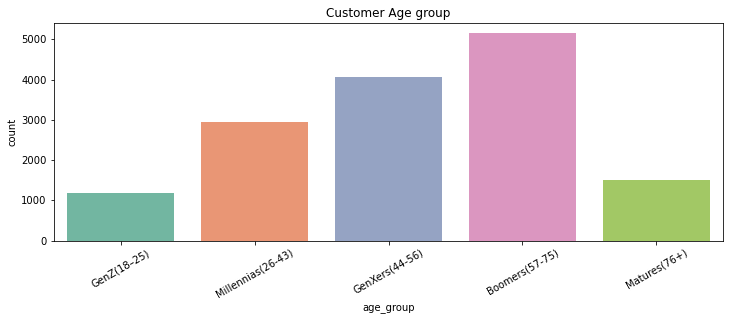

In [78]:
#Group the age ranges

fig = plt.figure(figsize = (12,4))
sns.countplot(x='age_group',data=profile_df)
plt.xticks(rotation=30)
plt.title('Customer Age group')


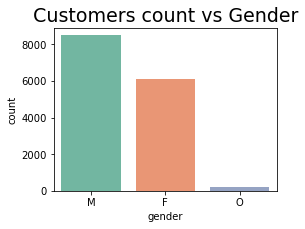

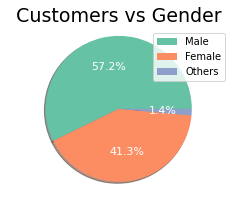

In [23]:
#Gender distribution

plt.figure(figsize=[4,3])
sns.countplot(x= profile_df['gender'], order = profile_df['gender'].value_counts().index)

plt.title('Customers count vs Gender', fontsize=19)

#Gender Distribution in Percentage

gender = profile_df['gender'].value_counts()

plt.figure(figsize=(4, 3))
plt.pie(gender, labels=['Male', 'Female' , 'Others'], shadow=True, autopct='%1.1f%%', 
            textprops={'color': "w", 'fontsize': 11})

plt.axis('equal')
plt.title('Customers vs Gender', fontsize=19)
plt.legend(loc='best')

In [24]:
gender

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [25]:
#Analyze income:

profile_df['customer_income'].describe()


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: customer_income, dtype: float64

Text(0.5, 0, 'Salary(USD)')

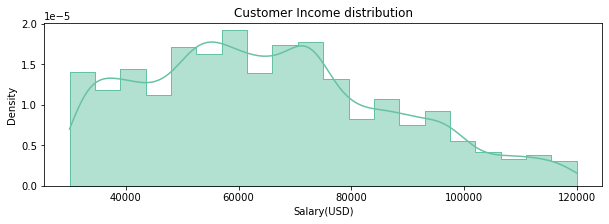

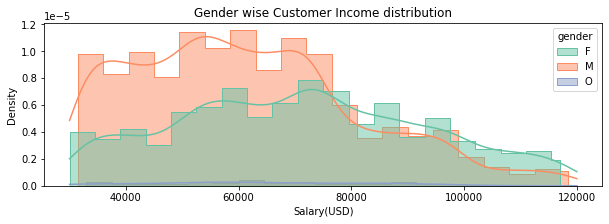

In [26]:
#Income distribution

plt.figure(figsize=[10,3])
sal_hist1 = sns.histplot(data = profile_df, x = 'customer_income',  multiple = "dodge",element = 'step', 
                        bins = 20, kde = True ,stat = 'density' ).set_title("Customer Income distribution")
plt.xlabel("Salary(USD)")

#Income distribution by gender

plt.figure(figsize=[10,3])
sal_hist = sns.histplot(data = profile_df, x = 'customer_income', hue = 'gender', 
                        multiple = "dodge",element = 'step', bins = 20, kde = True ,stat = 'density' ).set_title("Gender wise Customer Income distribution")
plt.xlabel("Salary(USD)")

In [27]:
#Median Income

print("Median Income  : $",profile_df['customer_income'].median())

print("Median Income for Males  : $",profile_df[profile_df['gender']=='M']['customer_income'].median())

print("Median Income Females : $",profile_df[profile_df['gender']=='F']['customer_income'].median())

Median Income  : $ 64000.0
Median Income for Males  : $ 59000.0
Median Income Females : $ 71000.0


In [28]:
#profile_df['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d') 

Text(0, 0.5, 'Number of Customers or Test Subjects')

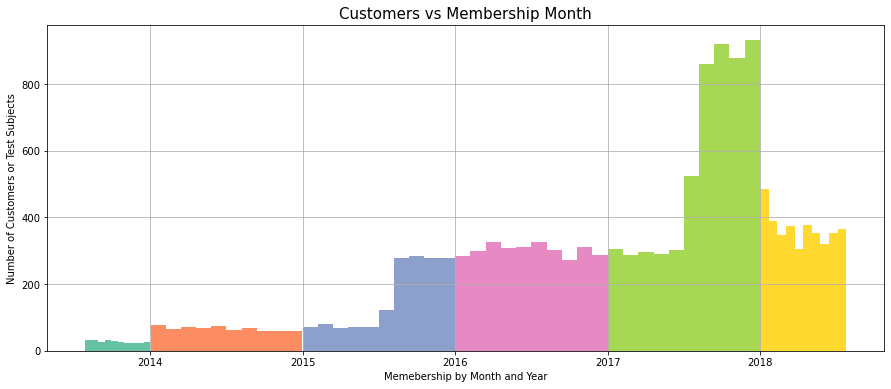

In [29]:
plt.figure(figsize=(15, 6))
profile_df['became_member_on'].groupby(profile_df['became_member_on'].dt.year).hist(bins=10)
plt.title('Customers vs Membership Month', fontsize=15)
plt.xlabel('Memebership by Month and Year')
plt.ylabel('Number of Customers or Test Subjects')

## Transcript: Data Exploration

In [30]:
#Transcript Data
transcript.head(4)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0


In [31]:
#Seperatng transaction and offer data from transcript dataframe
#offers, transactions = clean_transcript(transcript)


In [32]:

offers_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   167581 non-null  object
 1   event         167581 non-null  object
 2   time_in_days  167581 non-null  int64 
 3   offer_id      167581 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.4+ MB


In [33]:

transactions_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   138953 non-null  object
 1   event         138953 non-null  object
 2   time_in_days  138953 non-null  int64 
 3   amount        138953 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.3+ MB


In [34]:
offers_type = pd.merge(offers_df, portfolio_df, left_on='offer_id', right_on='offer_id', how='inner')
offers_type.head(2)

,customer_id,event,time_in_days,offer_id,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_name
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,offer_4
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,offer_4


In [35]:
data_all = pd.merge(offers_type, profile_df, left_on='customer_id', right_on='customer_id', how='inner')
data_all.head(2)

,customer_id,event,time_in_days,offer_id,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_name,gender,age,became_member_on,customer_income,membership_year,age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,offer_4,F,75,2017-05-09,100000.0,2017,Boomers(57-75)
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,offer_4,F,75,2017-05-09,100000.0,2017,Boomers(57-75)


[Text(0.5, 0, ''), Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Informational')]

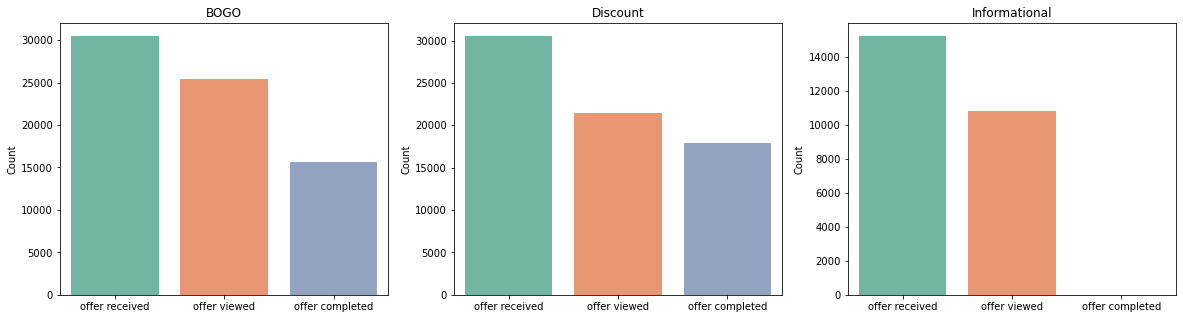

In [36]:
#Comparing offer recieved, viewed, completed by offer type

df_graph = offers_type.groupby(['event', 'offer_type'])['customer_id'].count().reset_index()
df_graph['event'] = pd.Categorical(df_graph['event'], ["offer received", "offer viewed", "offer completed"])

df_graph.sort_values('event', inplace = True)
df_graph = df_graph.rename(columns = {'customer_id':'customer_count'})

df_graph.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

sns.set_palette(sns.color_palette('Set2'))

ax = sns.barplot(x = 'event', y='customer_count', data=df_graph.query('offer_type == "bogo"'),ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot(x = 'event', y='customer_count', data=df_graph.query('offer_type == "discount"'),ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot(x = 'event', y='customer_count', data=df_graph.query('offer_type == "informational"'), ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

## RFM Analysis 

In this section we are going to perform Recency Frequecy Monetary value analysis of the customer. 

Its a metric used in marketing analytics to segments customers into groups based n the recency, frequency and monetary sum of the transaction made over a period of time to identifyt he best customers. 

In [37]:
#RFM Analysis

In [38]:
def rfm_funct(transactions = transactions_df):
    
    rfm_df = transactions.groupby('customer_id').agg(
    {'time_in_days': 'max' ,'amount': ['count', 'sum'] }).reset_index(col_level=1)
    
    rfm_df.columns = ['customer_id' , 'time_in_days'  ,'Frequency', 'Monetary']
    
    rfm_df = rfm_df.sort_values(['time_in_days', 'Frequency', 'Monetary'], ascending=False)
    
    rfm_df['Recency']  = rfm_df['time_in_days'].max() - rfm_df['time_in_days']
    
    rfm_df = rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary']]
    
    return rfm_df


rfm_df = rfm_funct(transactions_df)

In [39]:
rfm_df.head()

,customer_id,Recency,Frequency,Monetary
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69


In [40]:
#Discriptive analysis
display(rfm_df.describe())

,Recency,Frequency,Monetary
count,16578.000000,16578.000000,16578.000000
mean,3.202015,8.381771,107.096874
std,3.442917,5.009822,126.393939
min,0.000000,1.000000,0.050000
25%,1.000000,5.000000,23.682500
50%,2.000000,7.000000,72.410000
75%,5.000000,11.000000,150.937500
max,29.000000,36.000000,1608.690000


Text(0, 0.5, 'Customer count')

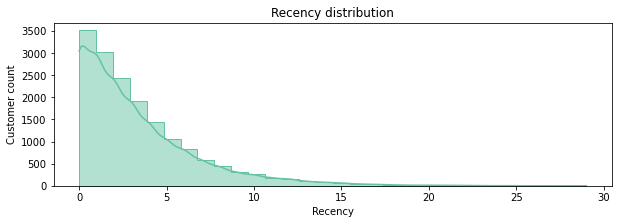

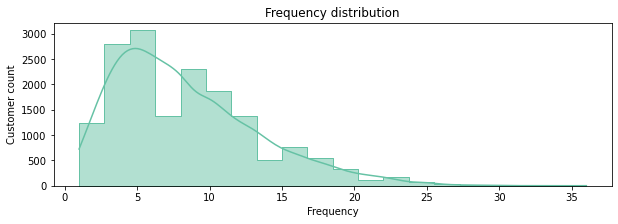

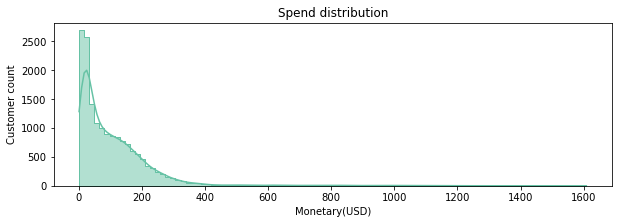

In [41]:
#Recency distribution

plt.figure(figsize=[10,3])
rfm_hist1 = sns.histplot(data = rfm_df, x = 'Recency',  multiple = "dodge",element = 'step', 
                        bins = 30, kde = True ,stat = 'count' ).set_title("Recency distribution")
plt.xlabel("Recency")
plt.ylabel("Customer count")


#Frequency distribution

plt.figure(figsize=[10,3])
rfm_hist1 = sns.histplot(data = rfm_df, x = 'Frequency',  multiple = "dodge",element = 'step', 
                        bins = 20, kde = True ,stat = 'count' ).set_title("Frequency distribution")
plt.xlabel("Frequency")
plt.ylabel("Customer count")


#Monetary distribution

plt.figure(figsize=[10,3])
rfm_hist1 = sns.histplot(data = rfm_df, x = 'Monetary',  multiple = "dodge",element = 'step', 
                        bins = 100, kde = True ,stat = 'count' ).set_title("Spend distribution")
plt.xlabel("Monetary(USD)")
plt.ylabel("Customer count")

Text(0.5, 1.0, 'Correlation Heatmap')

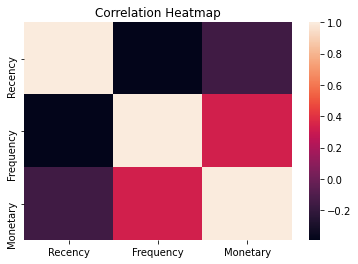

In [42]:
#Correlation between Recency, Frequency and monetary values

sns.heatmap(rfm_df.iloc[:,1:4].corr() )
plt.title('Correlation Heatmap')

We can observe some correlation between Frequency of purchase and the Monetary value. 

### Computation of RFM

Here we are going to determing how to compute the Recency,Frequency and Monetary data values. 

Ther are few approcahes to do this. Here we are going to check two such approches and check which shows the best results. 

The two approaches that we are going to check are:

#### Method 1: 
Compute the RFM codes by using K-Means clusteing algorithm. 

#### Method 2: 
Sort customers based on R, F, M values and then combine into RFM codes using traditional method,then use K-means clustering to determine cluster. 



In [43]:
#Method1:

#Since the recency, frequency and monetary data is highly skewed to right. We perform normalization 
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]))
rfm_normalized.columns = ['Recency_n', 'Frequency_n', 'Monetary_n']

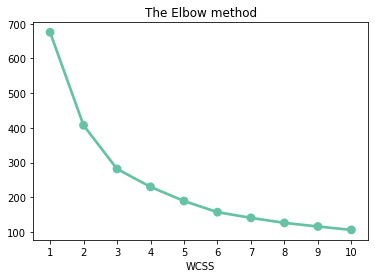

In [44]:
#Use elbow method to determine the optimum number of clusters needed for Method1

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i,init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)), y=wcss)
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.xlabel('WCSS')
plt.show()

The WCSS value starts slowing down after the 4th cluster. 'Elbow' at k=4, thus the optimal cluster is 4. 

Text(0.5, 0, 'Monetary')

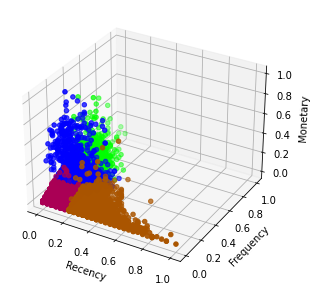

In [45]:
kmeans = KMeans(n_clusters = 4,init = 'k-means++', random_state = 42)
kmeans.fit(rfm_normalized)
centers = kmeans.cluster_centers_

sns.set_palette(sns.color_palette('Set2'))

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm_normalized['Recency_n'],rfm_normalized['Frequency_n'],rfm_normalized['Monetary_n'], 
           cmap = 'brg', c=kmeans.predict(rfm_normalized))


ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

#ax.scatter(centers[:,0], centers[:,1], c='black')

C:\Users\Arjun Achuthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


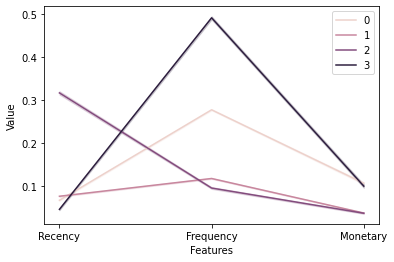

In [46]:
rfm_plot2 = rfm_normalized #pd.DataFrame(scaler.inverse_transform(rfm_normalized))
rfm_plot2.columns = rfm_df[['Recency', 'Frequency', 'Monetary']].columns
rfm_plot2['Index_a'] = rfm_df.index
rfm_plot2['cluster'] = kmeans.labels_

melted_rfm_normalized = pd.melt(rfm_plot2.reset_index(), id_vars=['Index_a','cluster'],
                                value_vars = ['Recency', 'Frequency', 'Monetary'],
                                var_name = 'Features', value_name = 'Value')

sns.lineplot('Features', 'Value', hue = 'cluster', data = melted_rfm_normalized)
plt.legend()

In [47]:
#Method 2:



#Assign recency variables to three equal quartile groups
r_labels = range(4,0,-1)
r_groups = pd.qcut(rfm_df['Recency'], q=4, labels= r_labels)
rfm_df['r_score'] = pd.DataFrame(r_groups)

#Assign recency variables to three equal quartile groups
f_labels = range(1,5)
f_groups = pd.qcut(rfm_df['Frequency'], q=4, labels= f_labels)
rfm_df['f_score'] = pd.DataFrame(f_groups)

#Assign recency variables to three equal quartile groups
m_labels = range(1,5)
m_groups = pd.qcut(rfm_df['Monetary'], q=4, labels= m_labels)
rfm_df['m_score'] = pd.DataFrame(m_groups)



In [48]:
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,r_score,f_score,m_score
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4


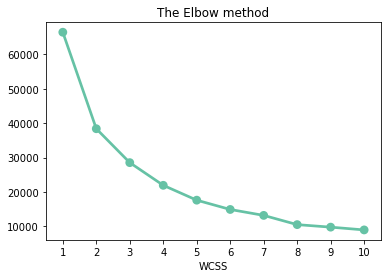

In [49]:
#Use elbow method to determine the optimum number of clusters needed for Method2
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i,init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_df.iloc[:,4:7])
    wcss.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)), y=wcss)
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.xlabel('WCSS')
plt.show()

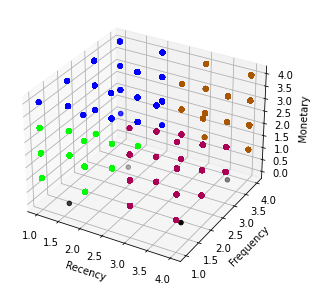

In [50]:
kmeans = KMeans(n_clusters = 4,init = 'k-means++', random_state = 42)
kmeans.fit(rfm_df.iloc[:,4:7])
centers = kmeans.cluster_centers_

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm_df['r_score'],rfm_df['f_score'],rfm_df['m_score'], 
           cmap = 'brg', c=kmeans.predict(rfm_df.iloc[:,4:7]))

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(centers[:,0], centers[:,1], c='black')

In [51]:
rfm_df_1 = rfm_df.iloc[:,4:7] #pd.DataFrame(scaler.inverse_transform(rfm_normalized))
rfm_df_1.columns = rfm_df_1[['r_score', 'f_score', 'm_score']].columns
rfm_df_1['index_a'] = rfm_df.index
rfm_df_1['cluster'] = kmeans.labels_

C:\Users\Arjun Achuthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


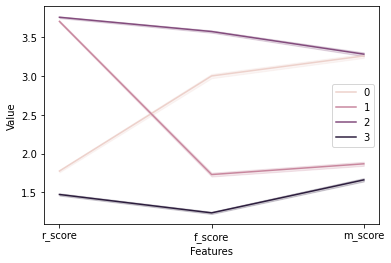

In [52]:
melted_rfm = pd.melt(rfm_df_1, id_vars=['index_a','cluster'],
                                value_vars = ['r_score', 'f_score', 'm_score'],
                                var_name = 'Features', value_name = 'Value')

sns.lineplot('Features', 'Value', hue = 'cluster', data = melted_rfm)
plt.legend()

0 - Low recency , Hight frequency and High monetary = High value wih high risk of leaving

1 - High reency, low frequency and low monetary = New Customer

2 - High recency , high frequency and high monetary = Best Customer

3 - Low recency, low frequency and low monetary = Low value customer

In [53]:
rfm_df['cluster']= rfm_df_1['cluster']

In [54]:
rfm_df.groupby('cluster').agg({
    'Recency': ['count','mean', 'median','min','max'],
    'Frequency': ['count','mean', 'median','min', 'max'],
    'Monetary': ['count','mean', 'median','min', 'max']
})

Recency                          Frequency                            \
          count      mean median min max     count       mean median min max   
cluster                                                                        
0          3243  4.637064      4   2  18      3243  10.134135      9   2  29   
1          4008  0.933134      1   0   2      4008   5.787425      6   1  11   
2          4871  0.814822      1   0   2      4871  13.282899     13   6  36   
3          4456  6.807899      6   3  29      4456   4.082361      4   1  11   

        Monetary                                       
           count        mean   median    min      max  
cluster                                                
0           3243  166.951230  145.970  14.43  1327.74  
1           4008   51.383860   29.200   0.05  1153.11  
2           4871  175.729388  157.270  12.91  1608.69  
3           4456   38.623153   21.425   0.05   150.63

In [55]:
rfm_df.head(2)

,customer_id,Recency,Frequency,Monetary,r_score,f_score,m_score,cluster
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4,2
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3,2


### Now lets analyze demographics of each clusters

In [56]:
profile_analysis = pd.merge(profile_df, rfm_df, left_on='customer_id', right_on='customer_id', how='inner')

In [57]:
profile_analysis.head(4)

,gender,age,customer_id,became_member_on,customer_income,membership_year,age_group,Recency,Frequency,Monetary,r_score,f_score,m_score,cluster
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,GenXers(44-56),7,3,77.01,1,1,3,3
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,Boomers(57-75),7,7,159.27,1,2,4,0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,Boomers(57-75),8,3,57.73,1,1,2,3
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,Boomers(57-75),4,3,36.43,2,1,2,3


In [58]:
profile_analysis_c0 = profile_analysis[profile_analysis['cluster']==0]
profile_analysis_c1 = profile_analysis[profile_analysis['cluster']==1]
profile_analysis_c2 = profile_analysis[profile_analysis['cluster']==2]
profile_analysis_c3 = profile_analysis[profile_analysis['cluster']==3]

[Text(0.5, 1.0, 'Cluster 3')]

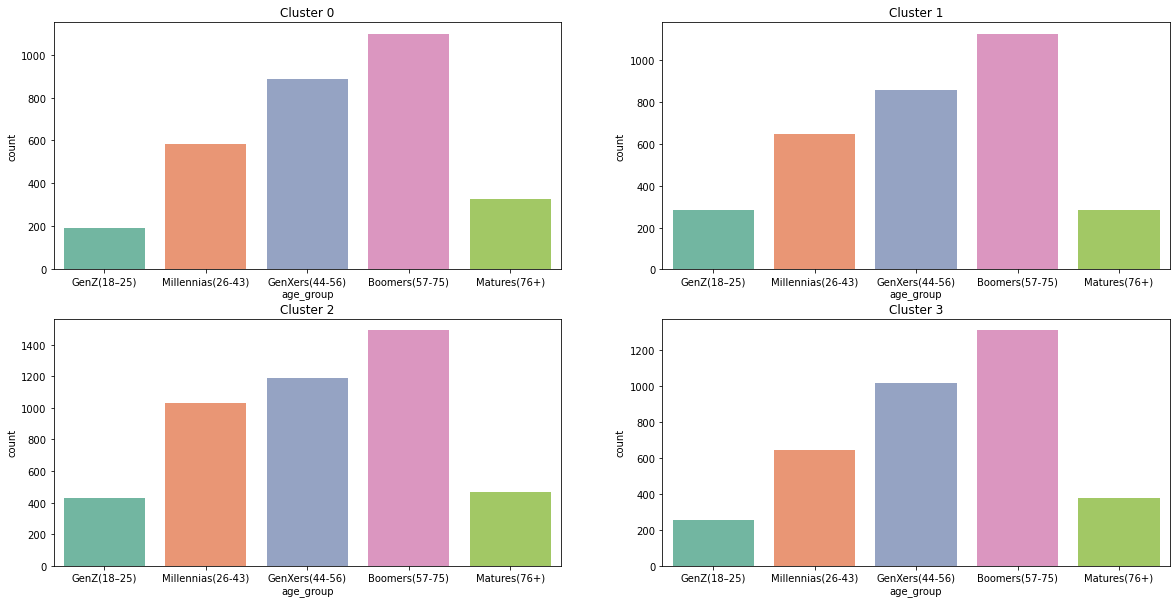

In [59]:
#Group the age ranges
sns.set_palette(sns.color_palette('Set2'))

fig, axs = plt.subplots( nrows = 2,ncols=2, figsize=(20, 10))

ax = sns.countplot(x='age_group',data=profile_analysis_c0,  ax= axs[0,0])
ax.set(title = 'Cluster 0')


ax = sns.countplot(x='age_group',data=profile_analysis_c1,  ax= axs[0,1])
ax.set( title = 'Cluster 1')

ax = sns.countplot(x='age_group',data=profile_analysis_c2,  ax= axs[1,0])
ax.set(title = 'Cluster 2')

ax = sns.countplot(x='age_group',data=profile_analysis_c3,  ax= axs[1,1])
ax.set( title = 'Cluster 3')


[Text(0.5, 1.0, 'Cluster 3')]

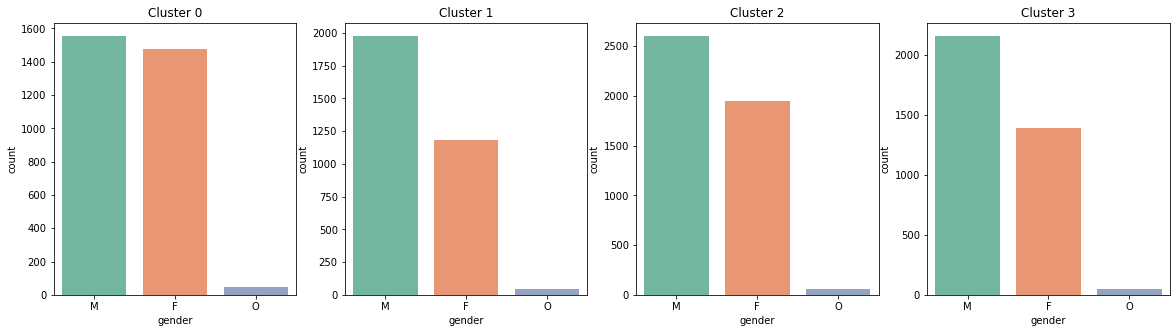

In [61]:
#Group the age ranges


fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
sns.set_palette(sns.color_palette('Set2'))

ax = sns.countplot(x= profile_analysis_c0['gender'], order = profile_analysis_c0['gender'].value_counts().index , ax= axs[0])
ax.set(title = 'Cluster 0')

ax = sns.countplot(x= profile_analysis_c1['gender'], order = profile_analysis_c1['gender'].value_counts().index , ax= axs[1])
ax.set(title = 'Cluster 1')

ax = sns.countplot(x= profile_analysis_c2['gender'], order = profile_analysis_c2['gender'].value_counts().index , ax= axs[2])
ax.set(title = 'Cluster 2')

ax = sns.countplot(x= profile_analysis_c3['gender'], order = profile_analysis_c3['gender'].value_counts().index , ax= axs[3])
ax.set(title = 'Cluster 3')


Text(0, 0.5, 'Salary(USD)')

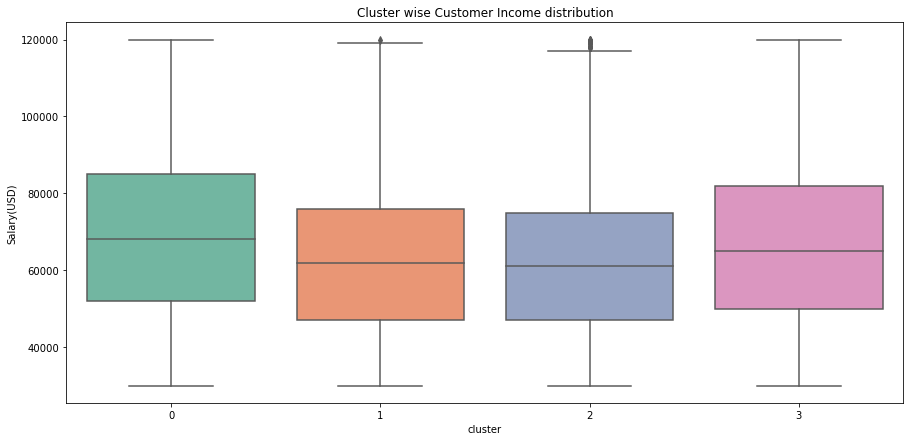

In [63]:
#Income distribution by gender
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=[15,7])
sal_hist = sns.boxplot(data = profile_analysis, x = 'cluster', y = 'customer_income' ).set_title("Cluster wise Customer Income distribution")
plt.ylabel("Salary(USD)")

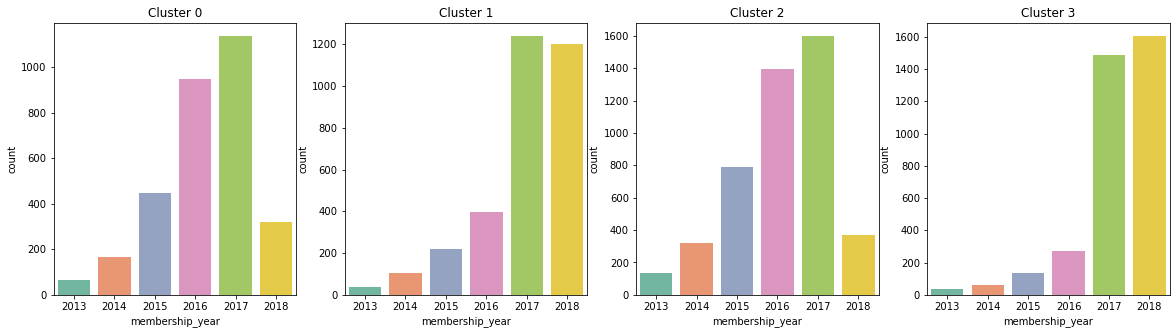

In [64]:
#Group the Membership year

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
sns.set_palette(sns.color_palette('Set2'))

ax = sns.countplot(x='membership_year',data=profile_analysis_c0, ax=axs[0]).set(title = 'Cluster 0')
ax = sns.countplot(x='membership_year',data=profile_analysis_c1, ax=axs[1]).set(title = 'Cluster 1')
ax = sns.countplot(x='membership_year',data=profile_analysis_c2, ax=axs[2]).set(title = 'Cluster 2')
ax = sns.countplot(x='membership_year',data=profile_analysis_c3, ax=axs[3]).set(title = 'Cluster 3')

### Offer analysis

In [65]:
offers, transactions = clean_transcript(transcript)

In [66]:
def offer_conversion(offers= offers):
    

    offer_stat = offers.groupby(['customer_id', 'offer_id']).agg({'completed': 'sum' ,'received': 'sum' , 'viewed': 'sum' })
    offer_stat.reset_index(level=[0,1], inplace=True)

    # Figure out if a offer was successful or not
    offer_success_temp = offer_stat['completed'] * offer_stat['viewed']
    offer_stat['offer_success'] = offer_success_temp.apply(lambda x: 1 if x > 0 else 0)
    
    offer_stat  = pd.merge(offer_stat, portfolio_df, left_on='offer_id', right_on='offer_id', how='inner')
    
    return offer_stat

offer_stat= offer_conversion(offers)

In [67]:
offer_analysis = pd.merge(offer_stat, rfm_df, left_on='customer_id', right_on='customer_id', how='inner')
offer_analysis.head(2)

,customer_id,offer_id,completed,received,viewed,offer_success,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_name,Recency,Frequency,Monetary,r_score,f_score,m_score,cluster
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,2,"[web, email, mobile]",10,7,discount,offer_10,0,8,127.6,4,3,3,2
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,"[web, email, mobile]",0,4,informational,offer_3,0,8,127.6,4,3,3,2


Text(0.5, 1.0, 'Customers count vs Gender')

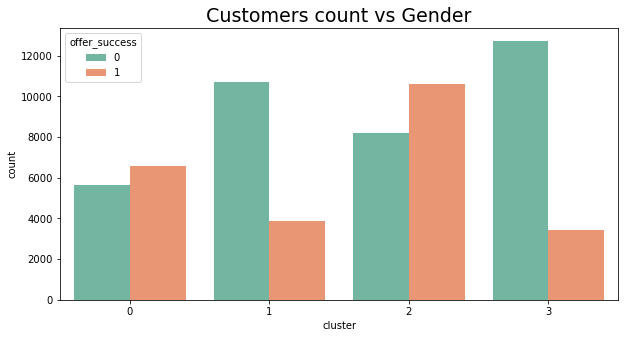

In [72]:
#Acceptance rate per offer

plt.figure(figsize=[10,5])
sns.countplot(x= offer_analysis['cluster'], hue = offer_analysis['offer_success'])

plt.title('Customers count vs Gender', fontsize=19)

<AxesSubplot:title={'center':'Cluster 3'}, xlabel='offer_name', ylabel='count'>

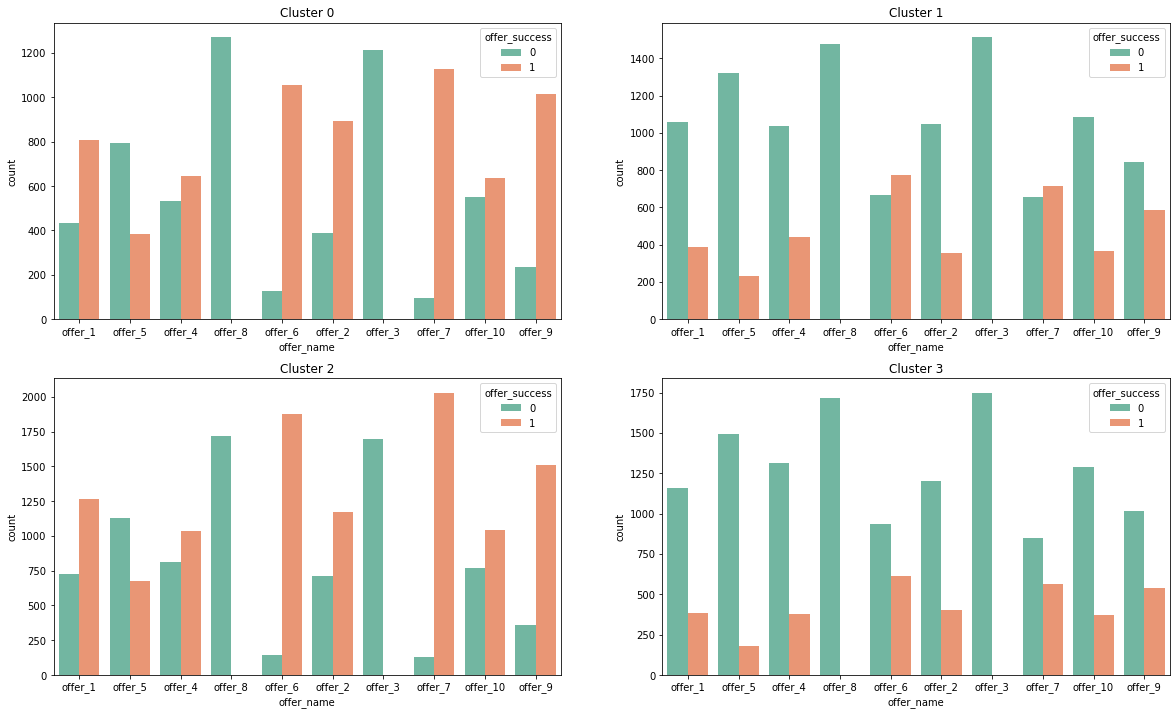

In [70]:
#Gender distribution

def plot_test(offer_analysis= offer_analysis):
    
    
    offer_analysis_c0 = offer_analysis[offer_analysis['cluster']==0]
    offer_analysis_c1 = offer_analysis[offer_analysis['cluster']==1]
    offer_analysis_c2 = offer_analysis[offer_analysis['cluster']==2]
    offer_analysis_c3 = offer_analysis[offer_analysis['cluster']==3]
    
    fig, axs = plt.subplots( nrows = 2,ncols=2, figsize=(20, 12))

    #plt.figure(figsize=[10,5])
    ax = sns.countplot(x= offer_analysis_c0['offer_name'], hue = offer_analysis_c0['offer_success'], 
                  order = offer_analysis['offer_name'].value_counts().index, ax= axs[0,0])

    ax.set(title = 'Cluster 0')



    #Gender distribution
    #plt.figure(figsize=[10,5])
    ax = sns.countplot(x= offer_analysis_c1['offer_name'], hue = offer_analysis_c1['offer_success'],
                 order = offer_analysis['offer_name'].value_counts().index, ax= axs[0,1])

    ax.set(title = 'Cluster 1')



    #Gender distribution

    #plt.figure(figsize=[10,5])
    ax = sns.countplot(x= offer_analysis_c2['offer_name'], hue = offer_analysis_c2['offer_success'],
                 order = offer_analysis['offer_name'].value_counts().index, ax= axs[1,0])

    ax.set(title = 'Cluster 2')



    #Gender distribution

    #plt.figure(figsize=[10,5])
    ax = sns.countplot(x= offer_analysis_c3['offer_name'], hue = offer_analysis_c3['offer_success'],
                 order = offer_analysis['offer_name'].value_counts().index, ax= axs[1,1])

    ax.set(title = 'Cluster 3')
    
    return(ax)
a = plot_test(offer_analysis)
a

In [73]:
offer_analysis.head(2)

,customer_id,offer_id,completed,received,viewed,offer_success,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_name,Recency,Frequency,Monetary,r_score,f_score,m_score,cluster
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,2,"[web, email, mobile]",10,7,discount,offer_10,0,8,127.6,4,3,3,2
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,"[web, email, mobile]",0,4,informational,offer_3,0,8,127.6,4,3,3,2
